In [1]:
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
print('Scanpy version:', sc.__version__)

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

Scanpy version: 1.9.1


/tmp/ipykernel_3765579/1644390834.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [75]:
!pip install scperturb --upgrade

In [76]:
from scperturb import *

# Prepare the data

In [77]:
!wget https://zenodo.org/record/7041849/files/DatlingerBock2021.h5ad

--2022-09-29 18:04:29--  https://zenodo.org/record/7041849/files/DatlingerBock2021.h5ad
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33600780 (32M) [application/octet-stream]
Saving to: ‘DatlingerBock2021.h5ad’

DatlingerBock2021.h 100%[===================>]  32.04M  6.59MB/s    in 9.7s    

2022-09-29 18:04:40 (3.30 MB/s) - ‘DatlingerBock2021.h5ad’ saved [33600780/33600780]



In [78]:
adata = sc.read('DatlingerBock2021.h5ad')
adata

AnnData object with n_obs × n_vars = 39194 × 25904
    obs: 'sample', 'cell_line', 'perturbation', 'perturbation_2', 'tissue_type', 'cancer', 'celltype', 'disease', 'organism', 'perturbation_type', 'perturbation_type_2', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [79]:
if 'processed' in adata.uns.keys():
    print('The dataset is already processed. Skipping processing...')
else:
    adata.layers['counts'] = adata.X.copy()

    # basic qc and pp
    sc.pp.filter_cells(adata, min_counts=1000)
    sc.pp.normalize_per_cell(adata)
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.log1p(adata)

    # high class imbalance
    adata = equal_subsampling(adata, 'perturbation', N_min=50)
    sc.pp.filter_genes(adata, min_cells=3)  # sanity cleaning

    # select HVGs
    n_var_max = 2000  # max total features to select
    sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
    sc.pp.pca(adata, use_highly_variable=True)
    sc.pp.neighbors(adata)

    adata.uns['processed'] = True

# E-distance

In [80]:
# pre-compute pairwise pca distances
pwd = pairwise_pca_distances(adata, 'perturbation', obsm_key='X_pca', dist='sqeuclidean', verbose=True)

100%|██████████| 41/41 [00:03<00:00, 13.12it/s]


In [81]:
# Compute E-distances
estats = edist(adata, obs_key='perturbation', obsm_key='X_pca', pwd=pwd, dist='sqeuclidean')

In [82]:
# square matrix, all pairs of perturbations get an e-distance
estats.head()

,control,LAT_2,LCK_2,JUND_2,ZAP70_2,FOS_2,EGR3_2,EGR4_1,PTPN11_2,LAT_1,...,EGR4_2,NFATC1_2,NFATC1_1,RELA_2,NFKB1_1,RELA_1,NFKB2_1,NFAT5_1,NR4A1_2,RUNX2_1
control,0.000000,2.265083,2.226002,1.543922,2.568344,0.241306,0.767086,0.682987,2.441368,3.887486,...,0.928202,0.917183,0.699194,1.550329,0.518731,1.761131,0.164890,1.117123,0.383756,0.481545
LAT_2,2.265083,0.000000,-0.627138,-0.242248,-0.598473,0.607526,-0.046850,0.331410,-0.012323,-0.261847,...,0.073836,3.664738,3.594882,0.538186,0.278663,-0.476598,0.094230,0.094366,0.805497,0.725016
LCK_2,2.226002,-0.627138,0.000000,0.422702,-0.086910,0.553294,0.276956,0.670221,-0.158497,-0.154911,...,0.653478,3.258877,3.174432,1.314961,0.581389,-0.299587,0.606488,0.388952,1.211374,0.927058
JUND_2,1.543922,-0.242248,0.422702,0.000000,-0.031832,0.457672,0.133115,0.552066,1.090427,0.593704,...,0.552410,3.686765,3.026783,0.406987,0.312383,0.157747,-0.220331,0.157825,0.449338,0.608725
ZAP70_2,2.568344,-0.598473,-0.086910,-0.031832,0.000000,0.926395,0.159421,0.565474,0.559036,-0.151555,...,0.281531,3.767488,3.055991,0.651328,0.242387,-0.024871,0.185370,0.199560,1.122890,0.613005


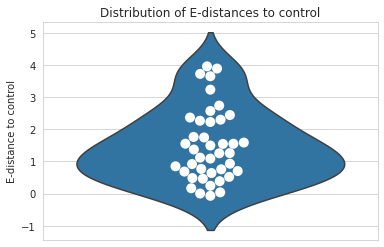

In [83]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=estats.loc['control'], inner=None)
    sns.swarmplot(data=estats.loc['control'], size=10, color='white')
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()

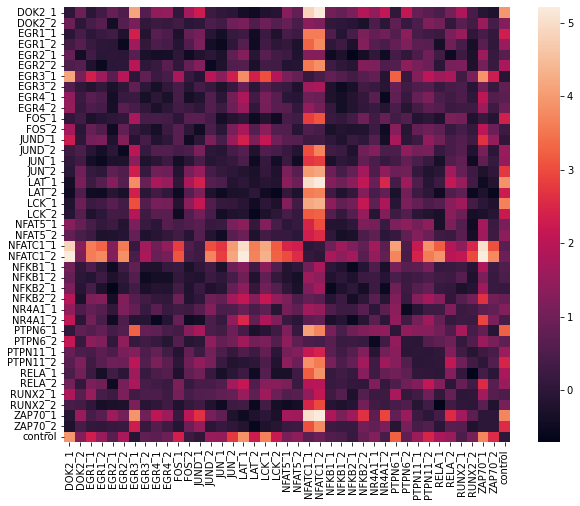

In [84]:
fig, ax = pl.subplots(1,1, figsize=[10,8])
order = estats.sort_index().index
sns.heatmap(estats.loc[order, order])
pl.show()

# E-testing

In [85]:
# e-testing (can be slow)
df = etest(adata, obs_key='perturbation', obsm_key='X_pca', dist='sqeuclidean', control='control', alpha=0.05, runs=100)

100%|██████████| 100/100 [01:39<00:00,  1.00it/s]


In [86]:
df.head()

,edist,pvalue,significant,pvalue_adj,significant_adj
DOK2_1,3.956278,0.00,True,0.000000,True
DOK2_2,1.258075,0.01,True,0.182093,False
EGR1_1,2.296924,0.00,True,0.000000,True
EGR1_2,1.549061,0.00,True,0.000000,True
EGR2_1,0.638693,0.07,False,0.549896,False


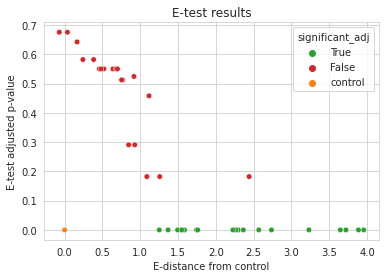

In [87]:
df.loc[df.index=='control', 'significant_adj'] = 'control'
with sns.axes_style('whitegrid'):
    sns.scatterplot(data=df, y='pvalue_adj', x='edist', hue='significant_adj', palette={True: 'tab:green', False: 'tab:red', 'control': 'tab:orange'}, s=30)
pl.title('E-test results')
pl.xlabel('E-distance from control')
pl.ylabel('E-test adjusted p-value')
pl.show()

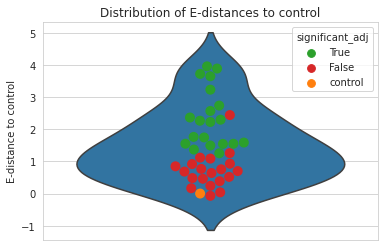

In [88]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=df, y='edist', inner=None)
    sns.swarmplot(data=df, x=[0]*len(df), y='edist', size=10, hue='significant_adj', dodge=False, palette={True: 'tab:green', False: 'tab:red', 'control': 'tab:orange'})
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()